In [1]:
import sys
sys.path.insert(0, '../code/')
from dismod_db import DismodDB
from two_level import TwoLevel
from plot_two_level import PlotTwoLevel
import numpy as np
import pandas as pd

#### Read in data

In [8]:
incidence_data = pd.read_csv('./data/maternal_obstruct_incidence.csv')
death_data = pd.read_csv('./data/maternal_obstruct_death.csv')
incidence_data = incidence_data[incidence_data['sex_id'] == 2]
death_data = death_data[death_data['sex_id'] == 2]
incidence_data.head()

,Unnamed: 0,measure,sex_id,age_start,age_end,location_name,year_start,year_end,mean,standard_error
1288,1288,Sincidence,2,0.0,0.019178,Canada,1990.0,1990.0,0.0,0.0
1289,1289,Sincidence,2,0.0,0.019178,United States,1990.0,1990.0,0.0,0.0
1290,1290,Sincidence,2,0.0,0.019178,Canada,1991.0,1991.0,0.0,0.0
1291,1291,Sincidence,2,0.0,0.019178,United States,1991.0,1991.0,0.0,0.0
1292,1292,Sincidence,2,0.0,0.019178,Canada,1992.0,1992.0,0.0,0.0


#### Sanity check -- run incidence only

In [3]:
data = incidence_data[incidence_data['standard_error'] > 0.]
data.reset_index(drop=True, inplace=True)
data.head()

,Unnamed: 0,measure,sex_id,age_start,age_end,location_name,year_start,year_end,mean,standard_error
0,1568,Sincidence,2,10.0,15.0,Canada,1990.0,1990.0,0.000003,7.760235e-07
1,1569,Sincidence,2,10.0,15.0,United States,1990.0,1990.0,0.000023,5.111896e-06
2,1570,Sincidence,2,10.0,15.0,Canada,1991.0,1991.0,0.000003,7.565842e-07
3,1571,Sincidence,2,10.0,15.0,United States,1991.0,1991.0,0.000023,4.993514e-06
4,1572,Sincidence,2,10.0,15.0,Canada,1992.0,1992.0,0.000003,7.448490e-07


In [4]:
integrand = ['Sincidence']
locations = ['United States', 'Canada']
rates = ['iota']
meas_noise_density = {'Sincidence': {'density': 'gaussian'}}
rates_parent_priors = [
    # rate priors for iota
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': 1e-2},\
    {'density': 'students', 'mean':0.0, 'std': 1e-2, 'nu': 5.},\
    {'density': 'gaussian', 'mean':0.0, 'std': 1e-2})]
rates_child_priors = [
    # rate priors for iota
    ({'density':'gaussian','mean': 0.0, 'std': 1.}, None, None)]
#---------change path------------
path_to_db = './data/maternal_obstruct_incidence.db'
db = DismodDB(data, locations, integrand,rates, rates_parent_priors, 
              rates_child_priors, meas_noise_density,path_to_db)

In [5]:
model = TwoLevel(db)

In [6]:
model.fit_both(zero_sum=True, tol=1e-10)

/home/prefix/dismod_at.release/bin/dismod_at ./data/maternal_obstruct_incidence.db init
./data/maternal_obstruct_incidence.db fit fixed
./data/maternal_obstruct_incidence.db predict fit_var
./data/maternal_obstruct_incidence.db set start_var fit_var
./data/maternal_obstruct_incidence.db fit both
./data/maternal_obstruct_incidence.db predict fit_var


{2: 'Canada', 1: 'United States', 0: 'all'}


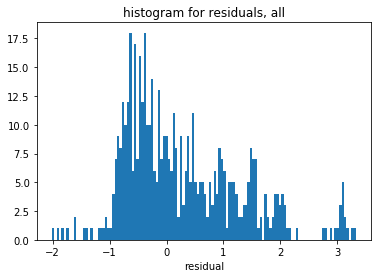

In [4]:
path = './data/'
plt = PlotTwoLevel(path, 'maternal_obstruct_incidence.db')
plt.plot_residuals('all', 'Sincidence')

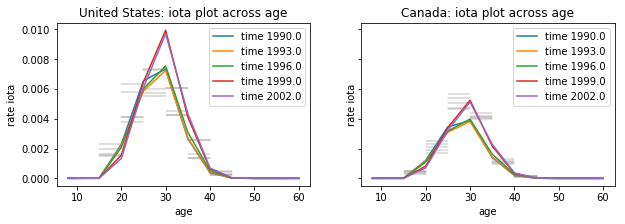

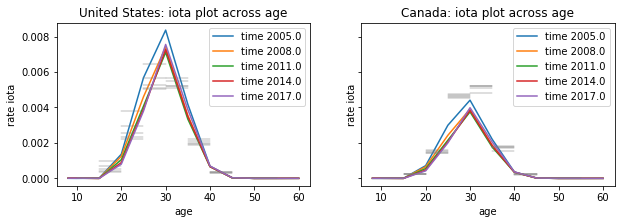

In [5]:
plt.plot_change_over_age('rate', 'iota', 'Sincidence', ['United States', 'Canada'])

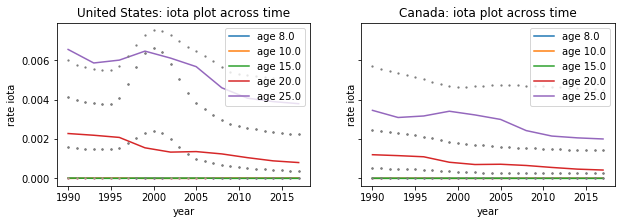

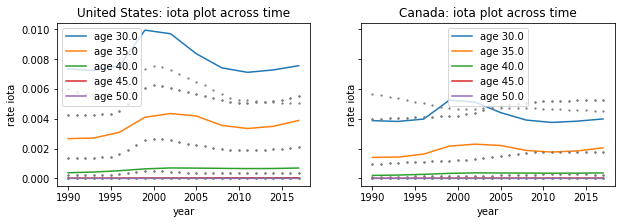

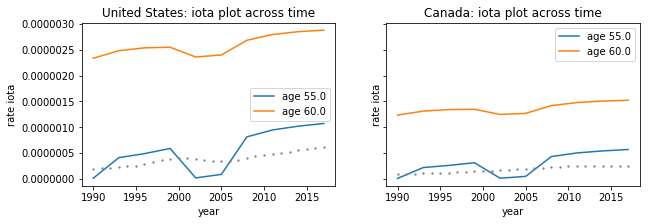

In [6]:
plt.plot_change_over_time('rate', 'iota', 'Sincidence', ['United States', 'Canada'])

#### Sanity check -- run one location with incidence and mortality data together
- filter out zeros

In [9]:
data = pd.concat([incidence_data, death_data])
data = data[(data['location_name'] == 'United States') & (data['standard_error'] > 0.)].reset_index(drop=True)
data.reset_index(drop=True, inplace=True)
data.head()

,Unnamed: 0,measure,sex_id,age_start,age_end,location_name,year_start,year_end,mean,standard_error
0,1569,Sincidence,2,10.0,15.0,United States,1990.0,1990.0,0.000023,0.000005
1,1571,Sincidence,2,10.0,15.0,United States,1991.0,1991.0,0.000023,0.000005
2,1573,Sincidence,2,10.0,15.0,United States,1992.0,1992.0,0.000022,0.000005
3,1575,Sincidence,2,10.0,15.0,United States,1993.0,1993.0,0.000022,0.000005
4,1577,Sincidence,2,10.0,15.0,United States,1994.0,1994.0,0.000022,0.000005


In [11]:
integrand = ['Sincidence', 'mtspecific', 'remission', 'mtexcess', 'mtother']
locations = ['United States']
rates = ['iota', 'rho', 'chi', 'omega']
meas_noise_density = {'Sincidence': {'density': 'gaussian'}, 'mtspecific': {'density': 'gaussian'}}
rates_parent_priors = [
    # rate priors for iota
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': 1e-2},\
    {'density': 'students', 'mean':0.0, 'std': 5e-3, 'nu': 5},\
    {'density': 'gaussian', 'mean':0.0, 'std': 1e-2}),
    # rho
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': .0001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001}),
    # chi
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': 1e-16},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001}),
    # omega
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': .0001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001})]
rates_child_priors = [
    # rate priors for iota
    ({'density':'gaussian','mean': 0.0, 'std': .1}, None, None),
    ({'density':'gaussian','mean': 0.0, 'std': .1}, None, None),
    ({'density':'gaussian','mean': 0.0, 'std': .1}, None, None),
    ({'density':'gaussian','mean': 0.0, 'std': .1}, None, None),]
#---------change path------------
path_to_db = './data/maternal_obstruct_mi.db'
db = DismodDB(data, locations, integrand,rates, rates_parent_priors, 
              rates_child_priors, meas_noise_density,path_to_db)

In [12]:
model2 = TwoLevel(db)

In [13]:
model2.fit_fixed(tol=1e-15, max_iter=500)

/home/prefix/dismod_at.release/bin/dismod_at ./data/maternal_obstruct_mi.db init
./data/maternal_obstruct_mi.db fit fixed
./data/maternal_obstruct_mi.db predict fit_var


{1: 'United States', 0: 'all'}


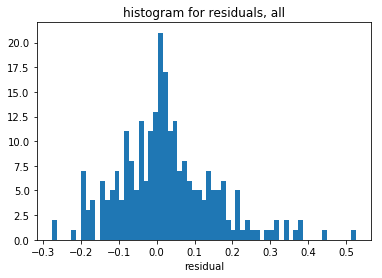

In [14]:
path = './data/'
plt = PlotTwoLevel(path, 'maternal_obstruct_mi.db')
plt.plot_residuals('all', 'Sincidence')

{1: 'United States', 0: 'all'}


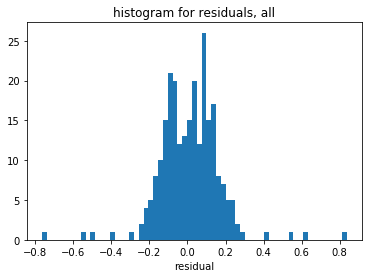

In [17]:
plt = PlotTwoLevel(path, 'maternal_obstruct_mi.db')
plt.plot_residuals('all', 'mtspecific')

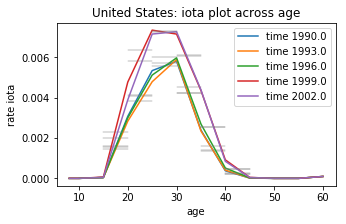

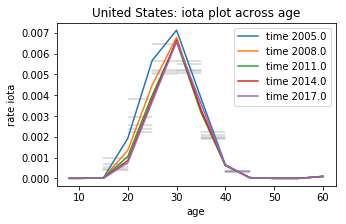

In [18]:
plt.plot_change_over_age('rate', 'iota', 'Sincidence', ['United States'])

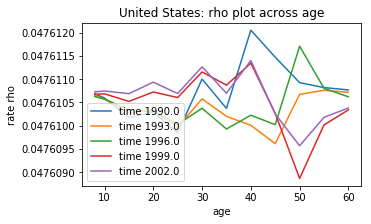

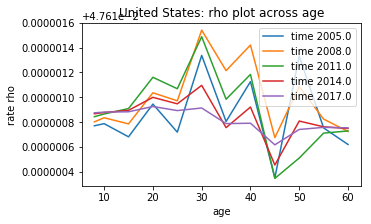

In [19]:
plt.plot_change_over_age('rate', 'rho', 'mtspecific', ['United States'],plot_data=False)

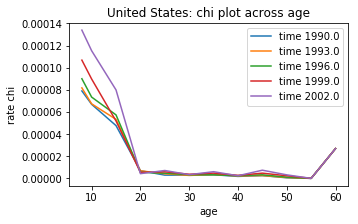

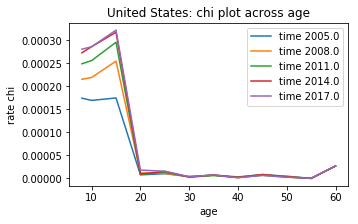

In [20]:
plt.plot_change_over_age('rate', 'chi', 'mtspecific', ['United States'],plot_data=False)

#### Not filtering out zeros
- setting standard_error to 0.01 (large in this case)

In [18]:
data = pd.concat([incidence_data, death_data])
data = data[(data['location_name'] == 'United States')].reset_index(drop=True).copy()
data.reset_index(drop=True, inplace=True)
for i, row in data.iterrows():
    if row['standard_error'] == 0:
        data.loc[i, 'standard_error'] = .01
data.head()

,Unnamed: 0,measure,sex_id,age_start,age_end,location_name,year_start,year_end,mean,standard_error
0,1289,Sincidence,2,0.0,0.019178,United States,1990.0,1990.0,0.0,0.01
1,1291,Sincidence,2,0.0,0.019178,United States,1991.0,1991.0,0.0,0.01
2,1293,Sincidence,2,0.0,0.019178,United States,1992.0,1992.0,0.0,0.01
3,1295,Sincidence,2,0.0,0.019178,United States,1993.0,1993.0,0.0,0.01
4,1297,Sincidence,2,0.0,0.019178,United States,1994.0,1994.0,0.0,0.01


In [19]:
integrand = ['Sincidence', 'mtspecific', 'remission', 'mtexcess', 'mtother']
locations = ['United States']
rates = ['iota', 'rho', 'chi', 'omega']
meas_noise_density = {'Sincidence': {'density': 'gaussian'}, 'mtspecific': {'density': 'gaussian'}}
rates_parent_priors = [
    # rate priors for iota
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': 1e-3},\
    {'density': 'students', 'mean':0.0, 'std': 2e-3, 'nu': 5},\
    {'density': 'gaussian', 'mean':0.0, 'std': 1e-2}),
    # rho
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': .0001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001}),
    # chi
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': 1e-16},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001}),
    # omega
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': .0001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001})]
rates_child_priors = [
    # rate priors for iota
    ({'density':'gaussian','mean': 0.0, 'std': .1}, None, None),
    ({'density':'gaussian','mean': 0.0, 'std': .1}, None, None),
    ({'density':'gaussian','mean': 0.0, 'std': .1}, None, None),
    ({'density':'gaussian','mean': 0.0, 'std': .1}, None, None),]
#---------change path------------
path_to_db = './data/maternal_obstruct_mi2.db'
db = DismodDB(data, locations, integrand,rates, rates_parent_priors, 
              rates_child_priors, meas_noise_density,path_to_db)

In [20]:
model3 = TwoLevel(db)

In [21]:
model3.fit_fixed(tol=1e-15, max_iter=500)

/home/prefix/dismod_at.release/bin/dismod_at ./data/maternal_obstruct_mi2.db init
./data/maternal_obstruct_mi2.db fit fixed
./data/maternal_obstruct_mi2.db predict fit_var


{1: 'United States', 0: 'all'}


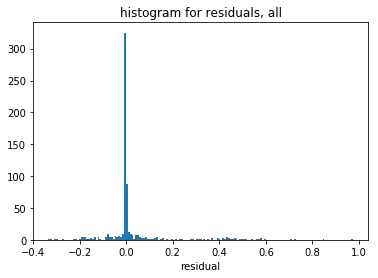

In [21]:
path = './data/'
plt = PlotTwoLevel(path, 'maternal_obstruct_mi2.db')
plt.plot_residuals('all', 'Sincidence')

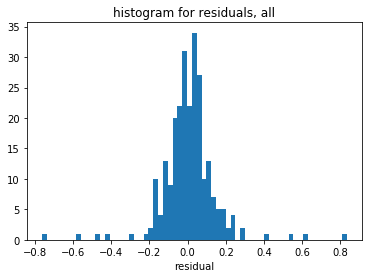

In [22]:
plt.plot_residuals('all', 'mtspecific')

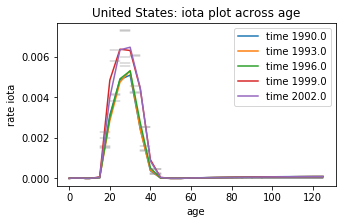

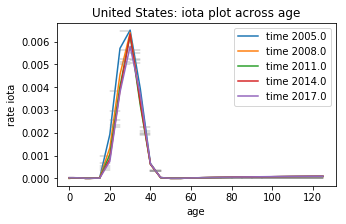

In [23]:
plt.plot_change_over_age('rate', 'iota', 'Sincidence', ['United States'])

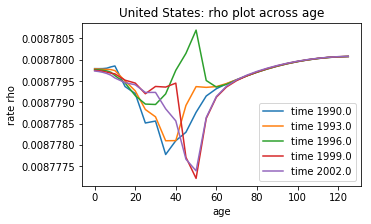

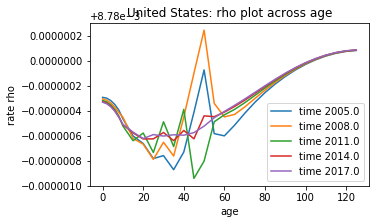

In [24]:
plt.plot_change_over_age('rate', 'rho', 'mtspecific', ['United States'],plot_data=False)

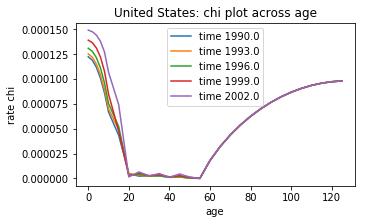

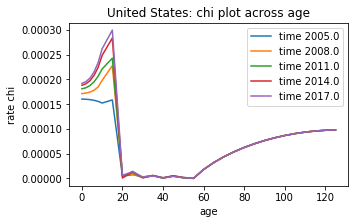

In [25]:
plt.plot_change_over_age('rate', 'chi', 'mtspecific', ['United States'],plot_data=False)

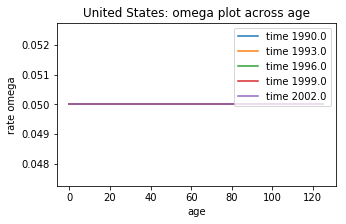

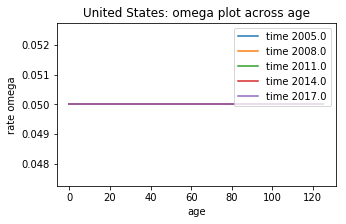

In [26]:
plt.plot_change_over_age('rate', 'omega', 'mtspecific', ['United States'],plot_data=False)

- setting standard_error to 1e-10 (small in this case)

In [31]:
data = pd.concat([incidence_data, death_data])
data = data[(data['location_name'] == 'United States')].reset_index(drop=True).copy()
data.reset_index(drop=True, inplace=True)
for i, row in data.iterrows():
    if row['standard_error'] == 0:
        data.loc[i, 'standard_error'] = 1e-10
data.head()

,Unnamed: 0,measure,sex_id,age_start,age_end,location_name,year_start,year_end,mean,standard_error
0,1289,Sincidence,2,0.0,0.019178,United States,1990.0,1990.0,0.0,1.000000e-10
1,1291,Sincidence,2,0.0,0.019178,United States,1991.0,1991.0,0.0,1.000000e-10
2,1293,Sincidence,2,0.0,0.019178,United States,1992.0,1992.0,0.0,1.000000e-10
3,1295,Sincidence,2,0.0,0.019178,United States,1993.0,1993.0,0.0,1.000000e-10
4,1297,Sincidence,2,0.0,0.019178,United States,1994.0,1994.0,0.0,1.000000e-10


In [32]:
integrand = ['Sincidence', 'mtspecific', 'remission', 'mtexcess', 'mtother']
locations = ['United States']
rates = ['iota', 'rho', 'chi', 'omega']
meas_noise_density = {'Sincidence': {'density': 'gaussian'}, 'mtspecific': {'density': 'gaussian'}}
rates_parent_priors = [
    # rate priors for iota
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': 1e-3},\
    {'density': 'students', 'mean':0.0, 'std': 5e-3, 'nu': 5},\
    {'density': 'gaussian', 'mean':0.0, 'std': 1e-2}),
    # rho
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': .0001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001}),
    # chi
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': 1e-16},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001}),
    # omega
    ({'density':'uniform','upper':.1,'lower':1e-16,'mean': .0001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001},\
    {'density': 'gaussian', 'mean':0.0, 'std': .001})]
rates_child_priors = [
    # rate priors for iota
    ({'density':'gaussian','mean': 0.0, 'std': .1}, None, None),
    ({'density':'gaussian','mean': 0.0, 'std': .1}, None, None),
    ({'density':'gaussian','mean': 0.0, 'std': .1}, None, None),
    ({'density':'gaussian','mean': 0.0, 'std': .1}, None, None),]
#---------change path------------
path_to_db = './data/maternal_obstruct_mi3.db'
db = DismodDB(data, locations, integrand,rates, rates_parent_priors, 
              rates_child_priors, meas_noise_density,path_to_db)

In [33]:
model4 = TwoLevel(db)

In [34]:
model4.fit_fixed(tol=1e-15, max_iter=500)

/home/prefix/dismod_at.release/bin/dismod_at ./data/maternal_obstruct_mi3.db init
./data/maternal_obstruct_mi3.db fit fixed
./data/maternal_obstruct_mi3.db predict fit_var


{1: 'United States', 0: 'all'}


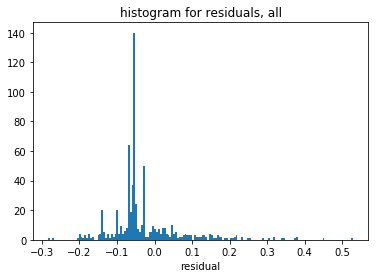

In [35]:
path = './data/'
plt = PlotTwoLevel(path, 'maternal_obstruct_mi3.db')
plt.plot_residuals('all', 'Sincidence')

- shift in residuals: 0s are predicted with nonzero values, around 1e-11

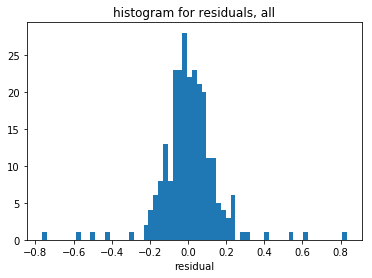

In [36]:
plt.plot_residuals('all', 'mtspecific')

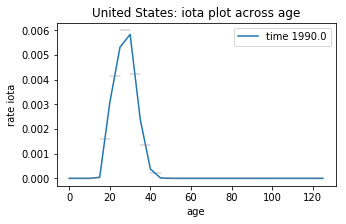

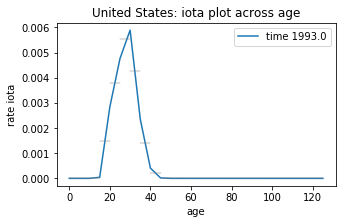

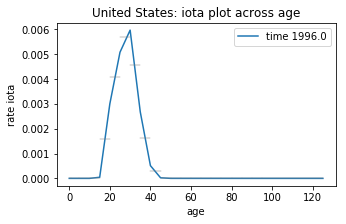

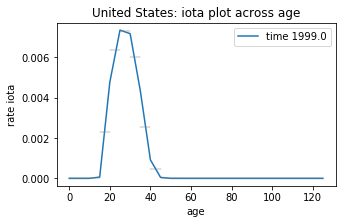

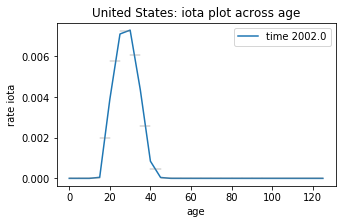

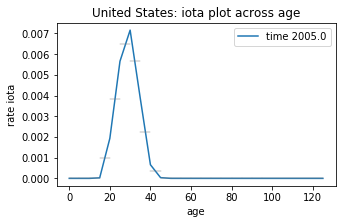

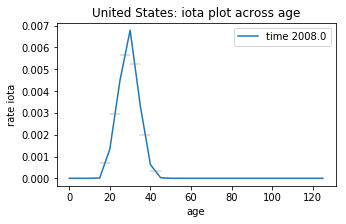

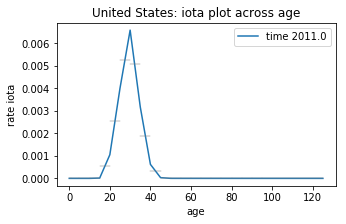

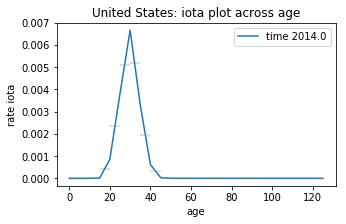

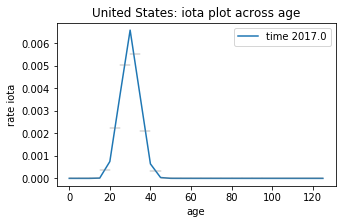

In [37]:
plt.plot_change_over_age('rate', 'iota', 'Sincidence', ['United States'], curve_per_plot=1)

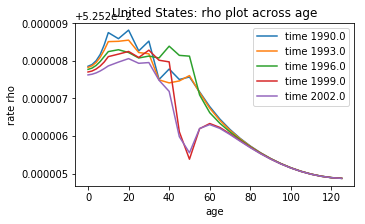

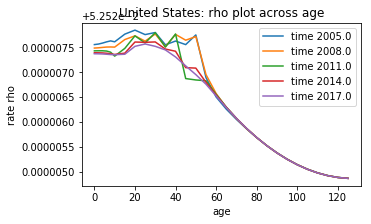

In [38]:
plt.plot_change_over_age('rate', 'rho', 'mtspecific', ['United States'],plot_data=False)

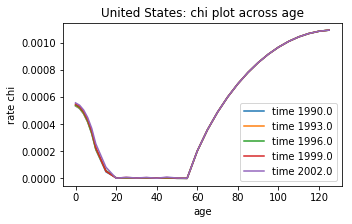

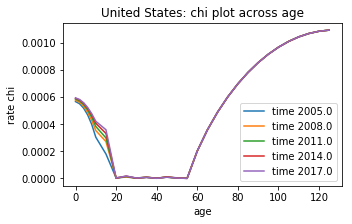

In [68]:
plt.plot_change_over_age('rate', 'chi', 'mtspecific', ['United States'],plot_data=False)

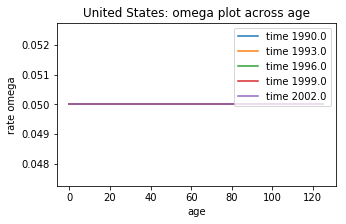

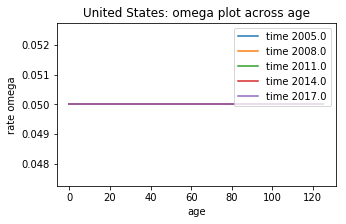

In [69]:
plt.plot_change_over_age('rate', 'omega', 'mtspecific', ['United States'],plot_data=False)